Olav de Clerck, Pierre Nikitits

# Introduction to Visual Computing: Crater Detection Project

**Code Structure**

1. Functions
- Preprocessing
- Possible crater detection
- Segmentation
- Features extraction

2. Dataset training
- Dataset parsing
- Train craters extraction
- SVM creation
- SVM visualisation

3. Testing
- Preprocessing
- Possible crater detection
- Possible crater segmentation and feature extraction
- Crater confirmation with SVM

4. Validation
- Full pipeline
- Random search for the best parameters

5. Testing
- Calculate the average error on the test dataset (using the parameters from validation)

---

**Part 1: Functions**
- Preprocessing
- Possible crater detection
- Segmentation
- Features extraction
- Error calculation

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from tqdm import tqdm

In [2]:
# Preprocessing

def apply_noise_reduction(image, kernel_size=1):
    kernel_size = int(kernel_size)
    kernel_size = max(1, kernel_size) # Kernel size must be at least 1
    if kernel_size % 2 == 0:
        kernel_size += 1 # Kernel size must be odd
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def enhance_contrast(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Enhance the contrast of the image using CLAHE.
    - image: Input image
    - clip_limit: Threshold for contrast limiting
    - tile_grid_size: Size of grid for histogram equalization
    """
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

In [3]:
# Possible crater detection

def apply_canny(image, low_threshold, high_threshold):
    return cv2.Canny(image, low_threshold, high_threshold)

def detect_craters(image, dp=1.5, min_dist=100, param1=100, param2=30, min_radius=2, max_radius=50):
    """
    Detect craters using Hough Circle Transform.
    - dp: Inverse ratio of the accumulator resolution to the image resolution.
    - min_dist: Minimum distance between detected centers.
    - param1: Upper threshold for the internal Canny edge detector.
    - param2: Threshold for center detection.
    - min_radius: Minimum crater radius to be detected.
    - max_radius: Maximum crater radius to be detected.
    """
    detected_circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, dp, min_dist,
                                        param1=param1, param2=param2, 
                                        minRadius=min_radius, maxRadius=max_radius)
    return detected_circles

def draw_circles(image, circles , color=(255, 0, 0)):
    """ Draw circles on the image. """
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            # Draw the outer circle
            cv2.circle(image, (i[0], i[1]), i[2], color, 2)
            # Draw the center of the circle
            # cv2.circle(image, (i[0], i[1]), 2, (0, 255, 0), 3)
    return image

In [4]:
# Segmentation

def segment_crater(image, circle):
    """Segment the crater based on the circle coordinates."""
    x, y, r = circle
    x = int(x)
    y = int(y)
    r = int(r*1.2)
    mask = np.zeros_like(image, dtype=np.uint8)
    cv2.circle(mask, [x, y], r, (255), thickness=-1)
    segmented_crater = cv2.bitwise_and(image, image, mask=mask)
    return segmented_crater

In [5]:
# Feature extraction

def extract_features(segmented_crater):
    """Extract features from a segmented crater for classification."""
    
    # Feature 1: Standard Deviation of Intensities
    #texture_std = np.std(segmented_crater)

    # Feature 2: Shape - Circularity
    # Note: Circularity = 4*pi*Area / Perimeter^2, perfect circle has circularity = 1
    contours, _ = cv2.findContours(segmented_crater, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)
        circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter != 0 else 0
    else:
        circularity = 0

    # Feature 3: Edge Sharpness
    # Laplacian variance (higher values indicate sharper edges)
    laplacian_var = cv2.Laplacian(segmented_crater, cv2.CV_64F).var()

    features = [circularity, laplacian_var] # texture_std
    return features

In [6]:
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found at {image_path}")
    return image

In [7]:
# Error calculation

def crater_matching_error(predictions, labels):
    # Flatten the prediction and label arrays if they are nested
    # print("pred:" , predictions)
    # print("labels:" , labels)
    labels = labels[0]
    predictions = predictions[0]
    
    # Compute the pairwise Euclidean distance between predicted and labeled crater centers
    distances = cdist(predictions[:, :2], labels[:, :2])
    
    # Use the Hungarian algorithm to find the minimum distance matching
    row_ind, col_ind = linear_sum_assignment(distances)
    
    # Compute the sum of the distances for the matched craters
    matched_distances = distances[row_ind, col_ind].sum()
    
    # Normalize by the larger of the number of predictions or labels
    max_craters = max(len(predictions), len(labels))
    
    # Define the error as the average distance per crater
    error = matched_distances / max_craters
    
    return error #, row_ind, col_ind

---
**Part 2: Dataset training**
- Dataset parsing
- Train craters extraction
- SVM creation
- SVM visualisation

In [8]:
# Dataset parsing

def get_file_names(directory):
    file_names_without_extensions = []
    try:
        # Check if the directory exists
        if os.path.exists(directory):
            # Get all the entries in the directory
            entries = os.listdir(directory)
            # Filter out the files, remove the extensions, and append to the list
            file_names_without_extensions = [os.path.splitext(entry)[0] for entry in entries if os.path.isfile(os.path.join(directory, entry))]
    except Exception as e:
        print(f"An error occurred: {e}")
    
    return file_names_without_extensions


train_images_path = "crater_dataset/train/images/"
train_labels_path = "crater_dataset/train/labels/"
train_files_names = get_file_names(train_images_path)

test_images_path = "crater_dataset/test/images/"
test_labels_path = "crater_dataset/test/labels/"
test_files_names = get_file_names(test_images_path)

valid_images_path = "crater_dataset/valid/images/"
valid_labels_path = "crater_dataset/valid/labels/"
valid_files_names = get_file_names(valid_images_path)

In [9]:
def parse_label(label_file):
    """Parse label file and convert to YOLO format."""
    with open(label_file, 'r') as file:
        lines = file.readlines()

    yolo_labels = []
    for line in lines:
        _, cx, cy, w, h = map(float, line.split())

        # Convert to pixel numbers (from normalised values range [0,1])
        cx = int(cx*640)
        cy = int(cy*640)
        w = int(w*640)
        h = int(h*640)

        # Convert to YOLO format: [x_center, y_center, width, height]
        yolo_label = [cx, cy, w, h]
        yolo_labels.append(yolo_label)
    
    return np.array(yolo_labels)

In [10]:
def plot_with_boxes(image, boxes):
    """Plot the image with bounding boxes."""
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap='gray')

    for box in boxes:
        # Convert [x_center, y_center, width, height] to [x1, y1, width, height]
        x_center, y_center, width, height = box
        x1 = x_center - (width / 2)
        y1 = y_center - (height / 2)

        rect = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

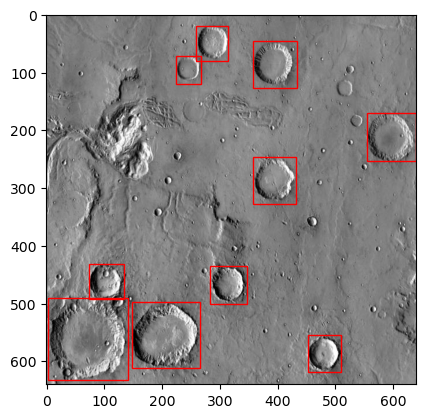

In [11]:
labels_1 = parse_label(train_labels_path + train_files_names[0] + '.txt')
image_1 = load_image(train_images_path + train_files_names[0] + '.jpg')

# Checking the data is correctly loaded
plot_with_boxes(image_1, labels_1)

In [12]:
# Making the full datasets (can be simplified)

# Train
training_images = []
training_labels = []

for file_name in train_files_names:
    image = load_image(train_images_path + file_name + '.jpg')
    label = parse_label(train_labels_path + file_name + '.txt')
    training_images.append(image)
    training_labels.append(label)

print(f"Train: {len(training_images)} images and {len(training_labels)} labels")

# Test
test_images = []
test_labels = []

for file_name in test_files_names:
    image = load_image(test_images_path + file_name + '.jpg')
    label = parse_label(test_labels_path + file_name + '.txt')
    test_images.append(image)
    test_labels.append(label)

print(f"Test : {len(test_images)} images and {len(test_labels)} labels")

# Valid
valid_images = []
valid_labels = []

for file_name in valid_files_names:
    image = load_image(valid_images_path + file_name + '.jpg')
    label = parse_label(valid_labels_path + file_name + '.txt')
    valid_images.append(image)
    valid_labels.append(label)

print(f"Valid: {len(valid_images)} images and {len(valid_labels)} labels")


Train: 98 images and 98 labels
Test : 19 images and 19 labels
Valid: 26 images and 26 labels


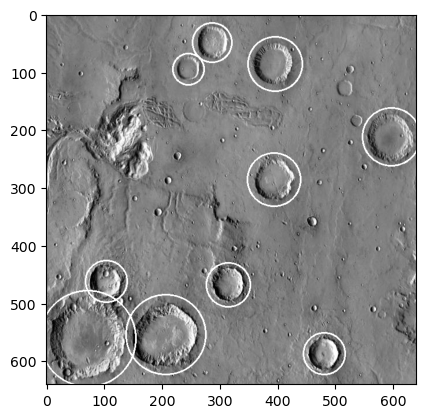

Features : [texture_std, circularity, laplacian_var]
[0.8872286065596807, 56.839287109375]
[0.8954460733745881, 190.4795068359375]
[0.8555117847343915, 181.29281789472105]
[0.888846630344463, 70.504072265625]
[0.8858597221715703, 87.2677880859375]
[0.8760853884732636, 39.4820751953125]
[0.8759059139727378, 77.45137202203264]
[0.8905962895628353, 89.47291015625]
[0.888846630344463, 86.78017578125]
[0.8896904402482245, 79.799501953125]

681 craters in train dataset


In [13]:
# Train craters extraction
# Segment the train images, compute the features for each crater

all_crater_features = []

for i in range(98):

    image = training_images[i]
    labels_box = training_labels[i]

    # Convert labels from box to circles
    labels_circles = []
    for label in labels_box:
        x , y , h , w = label
        r = int( (h+w)*0.3 )
        labels_circles.append([x,y,r])

    labels_circles = np.expand_dims(labels_circles, axis=0)

    image_with_c = draw_circles(image.copy() , labels_circles)

    if i == 0:
        plt.imshow(image_with_c, cmap='gray')
        plt.show()
        print("Features : [texture_std, circularity, laplacian_var]")
    
    for circle in labels_circles[0]:
        seg_crater = segment_crater(image , circle)
        features = extract_features(seg_crater)

        all_crater_features.append(features)

        if i == 0:
            print(features)

            # plt.figure(figsize=(2, 2))
            # plt.imshow(seg_crater, cmap='gray')

print(f"\n{len(all_crater_features)} craters in train dataset")


In [14]:
# SVM creation

# Feature normalisation
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(all_crater_features)
# Use the same scaler to transform test data

print(X_train_scaled)

[[0.97507323 0.01507891]
 [0.98843479 0.05158031]
 [0.92350186 0.04907114]
 ...
 [0.95150645 0.00647203]
 [0.95150645 0.00644352]
 [0.92012634 0.00443099]]


In [15]:
# Reducing the features
pca = PCA(n_components=2)
reduced_features = X_train_scaled # pca.fit_transform(X_train_scaled)

# Train a one-class SVM
oc_svm = OneClassSVM(kernel='rbf', nu=0.1 , gamma=10)  # nu is an upper bound on the fraction of training errors
oc_svm.fit(reduced_features)

OneClassSVM(gamma=10, nu=0.1)

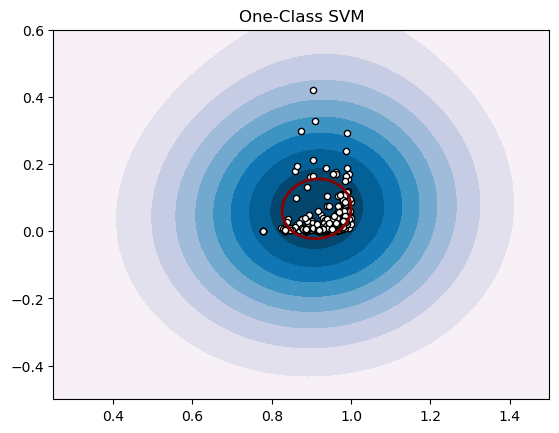

In [16]:
# SVM visualisation

# Create a grid to evaluate the model
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
Z = oc_svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Make sure the starting point of linspace is less than Z.min()
levels_start = min(Z.min(), -1)  # For example, start from Z.min() or -1, whichever is smaller
levels = np.linspace(levels_start, Z.max(), 10)  # Adjust the number of levels as needed

plt.contourf(xx, yy, Z, levels=levels, cmap=plt.cm.PuBu)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')

all_crater_features_array = np.array(reduced_features)
plt.scatter(all_crater_features_array[:, 0], all_crater_features_array[:, 1], c='white', s=20, edgecolor='k')

plt.title("One-Class SVM")
plt.axis('tight')
plt.xlim(0.25, 1.5)
plt.ylim(-0.5, 0.6)
plt.show()

---
**Part 3: Testing**
- Preprocessing
- Possible crater detection
- Possible crater segmentation and feature extraction
- Crater confirmation with SVM

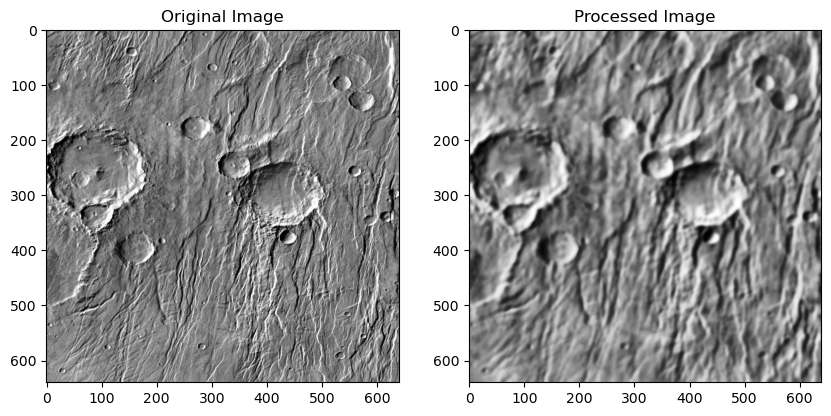

In [17]:
# Preprocessing

test_image_1 = test_images[4]

test_image_1_nr = apply_noise_reduction(test_image_1 , kernel_size=17)
test_image_1_nr = enhance_contrast(test_image_1_nr , clip_limit=2 , tile_grid_size=(8,8))

# Display the result
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(test_image_1, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image_1_nr, cmap='gray')
plt.title('Processed Image')
plt.show()

Craters [x , y , r] :
48 potential craters


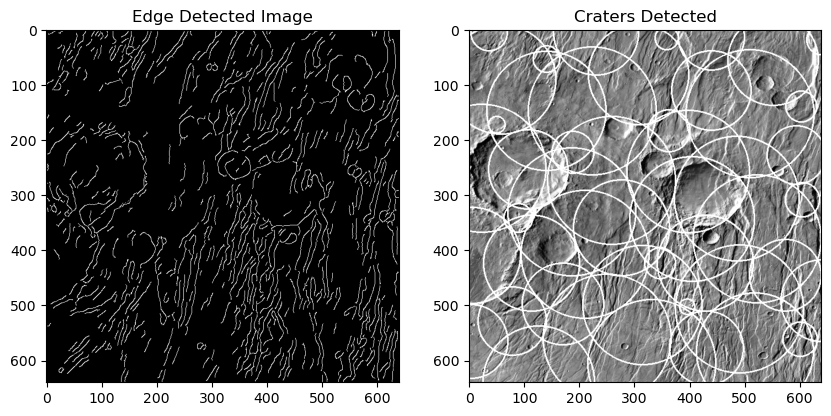

In [18]:
# Possible crater detection

# Edge detection
edges = apply_canny(test_image_1_nr , low_threshold=103 , high_threshold=162)

# Detect craters
circles = detect_craters(edges, dp=2.2, min_dist=80, param1=93, param2=30, min_radius=1, max_radius=117)

print("Craters [x , y , r] :")
# problem if no craters found: circles is None (not an empty array)
if circles is None:
    circles = [[]]
print(f"{len(circles[0])} potential craters")

# Draw detected craters on the original image
result_image = draw_circles(test_image_1.copy(), circles)

# Display the result
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detected Image')

plt.subplot(1, 2, 2)
plt.imshow(result_image, cmap='gray')
plt.title('Craters Detected')
plt.show()

In [19]:
# Possible crater segmentation and feature extraction

print("Features : [texture_std, circularity, laplacian_var]")

my_image_feature_array = []

for circle in circles[0]:
    seg_crater = segment_crater(image, [circle[0] , circle[1] , circle[2]*1.2])
    features = extract_features(seg_crater)
    my_image_feature_array.append(features)

    # plt.figure(figsize=(2, 2))
    # plt.imshow(seg_crater, cmap='gray')

# Feature Normalisation
my_image_feature_scaled = scaler.fit_transform(my_image_feature_array)
# PCA
my_image_feature_reduced = my_image_feature_scaled # pca.fit_transform(my_image_feature_scaled)

print(my_image_feature_scaled[0]) # What ?
print(my_image_feature_reduced[0])


Features : [texture_std, circularity, laplacian_var]
[0.89415877 0.58308417]
[0.89415877 0.58308417]


5 craters confirmed by SVM
Prediction:
[[[573 445  64]
  [599 562  30]
  [346 423  28]
  [603 309  30]
  [601 139  28]]]


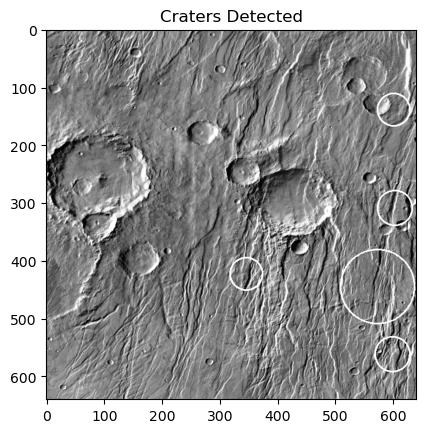

In [20]:
# Crater confirmation with SVM

y_pred = oc_svm.predict(my_image_feature_reduced)

confirmed_craters_circles = []
for i in range(len(y_pred)):
    if y_pred[i] == 1: # +1 or -1 for correct prediction ???
        x,y,r = circles[0][i]

        confirmed_craters_circles.append([int(x) , int(y) , int(r)])

confirmed_craters_circles = np.array([confirmed_craters_circles])
print(f"{len(confirmed_craters_circles[0])} craters confirmed by SVM")

print("Prediction:")
print(confirmed_craters_circles)

# # To compare with the labels
# print("Labels:")

# labels_circles = []
# for label in test_labels[4]:
#     x , y , h , w = label
#     r = int( (h+w)*0.3 )
#     labels_circles.append([x,y,r])
# print(np.array([labels_circles]))
# # --------------------------


final_image = draw_circles(test_image_1.copy(), confirmed_craters_circles)


plt.imshow(final_image, cmap='gray')
plt.title('Craters Detected')
plt.show()

---
**Part 4: Validation**
- Full pipeline
- Random search for the best parameters

In [21]:
# Full pipeline
"""
In:
    all params:
    - svm nu, gamma
    - noise reduction kernel_size
    - contrast clip_limit, tile_grid_size
    - canny low_threshold, high_threshold
    - hough dp, min_dist, param1, param2, min_radius, max_radius

    image, labels

Out:
    error compared to labels
    # images with labels
    # label list
"""

def full_pipeline(params , image , label , visualise=False):
    # Extract parameters
    kernel_size , clip_limit , tile_grid_size , low_threshold , high_threshold , dp , min_dist = params

    # Preprocessing
    image_nr = apply_noise_reduction(image , kernel_size=kernel_size)
    image_ct = enhance_contrast(image_nr , clip_limit=clip_limit , tile_grid_size=(tile_grid_size,tile_grid_size))

    # Possible crater detection
    edges = apply_canny(image_ct , low_threshold=low_threshold , high_threshold=high_threshold)
    circles = detect_craters(edges , dp=dp , min_dist=min_dist , param1=90 , param2=30 , min_radius=1 , max_radius=120)

    if circles is None:
        print("no prediction")
        circles = [] # or return 0% here

    # Segmentation and Feature extraction
    features_array = []
    for circle in circles[0]:
        seg_crater = segment_crater(image, [circle[0] , circle[1] , circle[2]*1.2])
        features = extract_features(seg_crater)
        features_array.append(features)

    # Feature normalisation
    features_array_sc = scaler.fit_transform(features_array)

    # SVM prediction
    y_pred = oc_svm.predict(features_array_sc)

    confirmed_craters_circles = []
    for i in range(len(y_pred)):
        if y_pred[i] == -1:
            x,y,r = circles[0][i]       
            confirmed_craters_circles.append([int(x) , int(y) , int(r)])
    confirmed_craters_circles = np.array([confirmed_craters_circles])

    labels_circles = []
    for box in label:
        x , y , h , w = box
        r = int( (h+w)*0.3 )
        labels_circles.append([x,y,r])
    labels_circles = np.expand_dims(labels_circles, axis=0)

    # Display if needed
    if visualise:
        image_with_c = draw_circles(image.copy() , confirmed_craters_circles , color=(255,0,0))

        image_with_c_l = draw_circles(image_with_c.copy() , labels_circles , color=(0,255,0))
        plt.imshow(image_with_c_l, cmap='gray')
        plt.show()


    # print(f"{len(confirmed_craters_circles[0])} predictions")
    if len(confirmed_craters_circles[0]) == 0:
        return 10000
    # Too few predictions
    if len(confirmed_craters_circles[0]) < 0.5 * len(labels_circles[0]):
        return 10000
    # Too many predictions
    if len(confirmed_craters_circles[0]) > 1.5 * len(labels_circles[0]):
        return 10000


    # Error calculation
    error = crater_matching_error(predictions=confirmed_craters_circles, labels=labels_circles)
    return error


In [30]:
# Random search

# Define the ranges for each parameter
param_ranges = {
    'kernel_size': np.arange(1, 21, 2),  # odd numbers from 1 to 31
    'clip_limit': np.linspace(1.0, 3.0, 20),  # values from 1.0 to 3.0
    'tile_grid_size': np.arange(2, 16, 2),  # even numbers from 2 to 16
    'low_threshold': np.arange(50, 200, 5),  # from 50 to 200 step 5
    'high_threshold': np.arange(100, 400, 5),  # from 100 to 300 step 5
    'dp': np.linspace(1.0, 3.0, 10),  # values from 1.0 to 3.0
    'min_dist': np.arange(5, 80, 5)  # from 5 to 80 step 5
}

# Random search implementation
def random_search(param_ranges, iterations, image, label):
    best_params = None
    best_error = float('inf')

    for _ in tqdm(range(iterations), desc="Searching"):
        # Randomly sample parameters
        params = [np.random.choice(param_ranges[key]) for key in sorted(param_ranges.keys())]
        
        # Evaluate the pipeline with the current set of parameters
        # current_error = full_pipeline(params=params, image=image, label=label)

        # Compute the cumulative error for the whole validation set
        current_error = 0
        for i in range(len(valid_images)):
            current_error += full_pipeline(params=params , image=valid_images[i] , label=valid_labels[i])

        
        # If the result from this set of parameters is better, save it
        if current_error < best_error:
            best_error = current_error
            best_params = params

            # Show the result if it's a good step
            print(best_error , best_params)
            # full_pipeline(params=best_params , image=test_images[4] , label=test_labels[4] , visualise=False)

    return best_params, best_error


# Perform the random search
best_params, best_error = random_search(param_ranges, 4000, test_images[4], test_labels[4])
print("Best Parameters:", best_params)
print("Best Error:", best_error)


Searching:   0%|          | 0/4000 [00:00<?, ?it/s]

Searching:   0%|          | 1/4000 [00:08<9:07:44,  8.22s/it]

260000 [1.631578947368421, 2.7777777777777777, 265, 5, 80, 15, 12]


Searching:   0%|          | 6/4000 [00:47<8:27:18,  7.62s/it] 

210511.8830746007 [1.4210526315789473, 1.6666666666666665, 100, 5, 120, 35, 14]


Searching:   0%|          | 11/4000 [01:02<4:12:40,  3.80s/it]

190713.10778970228 [2.789473684210526, 1.4444444444444444, 375, 11, 80, 40, 14]


Searching:   0%|          | 12/4000 [01:04<3:35:56,  3.25s/it]

160926.60807318994 [1.8421052631578947, 2.111111111111111, 345, 3, 145, 65, 12]


Searching:   0%|          | 14/4000 [01:25<6:54:03,  6.23s/it]

151065.88282864352 [1.736842105263158, 2.5555555555555554, 175, 13, 75, 55, 14]


Searching:   1%|          | 29/4000 [03:55<8:56:53,  8.11s/it] 


KeyboardInterrupt: 

---
**Part 5: Testing**
- Calculate the average error on the test dataset (using the parameters from validation)

---
Other: tool to adjust the parameters in real time (To remove)

In [23]:
# # Callback function for the trackbar
# def on_trackbar_change(val):
#     global need_update
#     need_update = True

# # Initialize global variables to track if update is needed
# need_update = True
# prev_trackbar_values = {}


# # Load image
# original_image = load_image('image_3.jpg')


# # Create a window
# cv2.namedWindow('Image Adjustments')

# # Create trackbars
# cv2.createTrackbar('Kernel size', 'Image Adjustments', 17, 30, on_trackbar_change)
# cv2.createTrackbar('Canny low', 'Image Adjustments', 103, 255, on_trackbar_change)
# cv2.createTrackbar('Canny high', 'Image Adjustments', 162, 255, on_trackbar_change)
# cv2.createTrackbar('dp', 'Image Adjustments', 22, 50, on_trackbar_change)
# cv2.createTrackbar('min_dist', 'Image Adjustments', 80, 200, on_trackbar_change)
# cv2.createTrackbar('canny int', 'Image Adjustments', 93, 200, on_trackbar_change)
# cv2.createTrackbar('center threshold', 'Image Adjustments', 30, 100, on_trackbar_change)
# cv2.createTrackbar('min_radius', 'Image Adjustments', 1, 50, on_trackbar_change)
# cv2.createTrackbar('max_radius', 'Image Adjustments', 117, 300, on_trackbar_change)

# while True:
#     current_trackbar_values = {
#         'Kernel size': cv2.getTrackbarPos('Kernel size', 'Image Adjustments'),
#         'Canny low': cv2.getTrackbarPos('Canny low', 'Image Adjustments'),
#         'Canny high': cv2.getTrackbarPos('Canny high', 'Image Adjustments'),
#         'dp': cv2.getTrackbarPos('dp', 'Image Adjustments') / 10.0,
#         'Min Dist': cv2.getTrackbarPos('min_dist', 'Image Adjustments'),
#         'canny int': cv2.getTrackbarPos('canny int', 'Image Adjustments'),
#         'center threshold': cv2.getTrackbarPos('center threshold', 'Image Adjustments'),
#         'Min Radius': cv2.getTrackbarPos('min_radius', 'Image Adjustments'),
#         'Max Radius': cv2.getTrackbarPos('max_radius', 'Image Adjustments')
#     }

#     if current_trackbar_values != prev_trackbar_values:
#         need_update = True
#         prev_trackbar_values = current_trackbar_values

#     if need_update:
#         need_update = False

#         # Get current positions of the trackbars
#         kernel_size = cv2.getTrackbarPos('Kernel size', 'Image Adjustments')
#         low_threshold = cv2.getTrackbarPos('Canny low', 'Image Adjustments')
#         high_threshold = cv2.getTrackbarPos('Canny high', 'Image Adjustments')
        
#         # Get current positions of the new trackbars
#         dp = cv2.getTrackbarPos('dp', 'Image Adjustments') / 10.0
#         min_dist = cv2.getTrackbarPos('min_dist', 'Image Adjustments')
#         if min_dist == 0: # Cannot be 0
#             min_dist = 1
#         param1 = cv2.getTrackbarPos('canny int', 'Image Adjustments')
#         param2 = cv2.getTrackbarPos('center threshold', 'Image Adjustments')
#         if param2 == 0: # Cannot be 0
#             param2 = 1
#         min_radius = cv2.getTrackbarPos('min_radius', 'Image Adjustments')
#         max_radius = cv2.getTrackbarPos('max_radius', 'Image Adjustments')

#         # Computations with current trackbar value :
#         blurred_image = apply_noise_reduction(original_image, kernel_size)
#         edges = apply_canny(blurred_image, low_threshold, high_threshold)
#         circles = detect_craters(edges, dp, min_dist, param1, param2, min_radius, max_radius)

#         result_image = draw_circles(original_image.copy(), circles)

#         # Combine images to display in 1 window
#         combined_image = np.hstack((blurred_image, edges, result_image))
#         cv2.imshow('Combined', combined_image)


    
#     # Break the loop when 'esc' is pressed
#     k = cv2.waitKey(1) & 0xFF
#     if k == 27:
#         break

# # Close all windows
# cv2.destroyAllWindows()
